# Big O
![](https://imgs.xkcd.com/comics/algorithms.png)

Machine measures time in 2 ways - for itself and for human. For itself in just counts ticks, for human it converts ticks to date/time. Converting involves
- leap years,
- [leap seconds](https://en.wikipedia.org/wiki/Leap_second) (last second was inserted on December 31, 2016, at 23:59:60 UTC),
- UTC shifts (Moscow +3) and
- NTP (network time protocol) synchronization (for auto correction).

How machine measures time? Clock is a microchip that generates frequency for CPU. It counts in TICKS that are usually order of nanosecond long (usual CPU frequency is 1-3 GHz … 8.8 - record). Clock generates just ticks, but there's also [TSC (Time Stamp Counter)](https://en.wikipedia.org/wiki/Leap_second) - mechanism that allow us to get the number of ticks from some moment (maybe machine last start, maybe first start depending on hardware implementation). It is very precise and it can be used to measure relatively short time intervals. CPU instruction for this - RDTSC (read TSC). TSC is sensible to sleep mode, so you cannot use it for long measurements that can involve hibernation.

In [6]:
import time
import datetime


print(time.gmtime()) # struct which represents human understanding with details
print(datetime.datetime.now()) # string of local time

print(time.time()) # seconds from... can you estmate the date of start?

time.struct_time(tm_year=2020, tm_mon=5, tm_mday=14, tm_hour=10, tm_min=40, tm_sec=29, tm_wday=3, tm_yday=135, tm_isdst=0)
2020-05-14 13:40:29.127780
1623.9632302
1589452829.1277802


Each CPU instruction takes some time to execute. Not always constant. But there is an upper limit. Also, operation length depends on data location and allocation.

In [57]:
import numpy as np
import sys

tmin, tmax = sys.float_info.max, 0

for i in range(10):
    a = np.random.rand(10000000)
    b = np.random.rand(10000000)
    start = time.perf_counter_ns()
    c = a + b
    end = time.perf_counter_ns()
    # x = sum(c)
    tmin = min(tmin, end - start)
    tmax = max(tmax, end - start)
print(f"per '+': {tmin / a.shape[0]:.4f} - {tmax / a.shape[0]:.4f} nsec")

per '+': 4.9683 - 13.6585 nsec


In [56]:
A = np.random.rand(4000, 4000)
B = np.random.rand(4000, 4000)
C = np.zeros(A.shape)

start = time.perf_counter_ns()
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        C[i, j] = A[i, j] * B[i, j]
end = time.perf_counter_ns()

print(f"per *: {(end - start) / A.shape[0] / A.shape[1]} nsec")

start = time.perf_counter_ns()
for j in range(A.shape[1]):
    for i in range(A.shape[0]):
        C[i, j] = A[i, j] * B[i, j]
end = time.perf_counter_ns()

print(f"per *: {(end - start) / A.shape[0] / A.shape[1]} nsec")

per *: 1249.8629375 nsec
per *: 1993.93150625 nsec


## But what we definintely know

elementwise vector sum from vector size


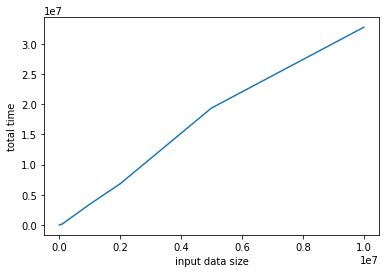

elementwise matrix mult


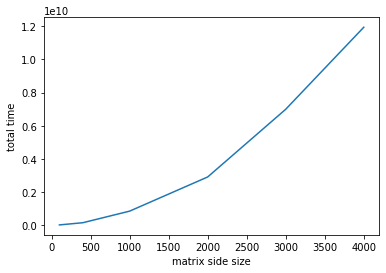

Vector sort


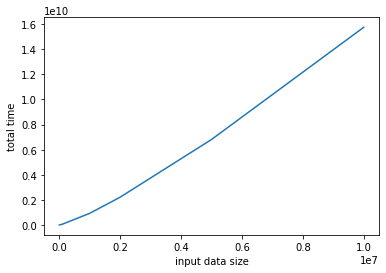

In [64]:
import numpy as np
import sys
import matplotlib.pyplot as plt

def sum_2_vectors(size):
    tmin = sys.float_info.max
    for i in range(5):
        a = np.random.rand(size)
        b = np.random.rand(size)
        start = time.perf_counter_ns()
        c = a + b
        end = time.perf_counter_ns()
        tmin = min(tmin, end - start)
    return tmin

def mult_2_matrices(size):
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    C = np.zeros(A.shape)
    start = time.perf_counter_ns()
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            C[i, j] = A[i, j] * B[i, j]
    end = time.perf_counter_ns()
    return end - start

def sort_1(size):
    tmin = sys.float_info.max
    for i in range(5):
        a = np.random.rand(size)
        start = time.perf_counter_ns()
        c = sorted(a)
        end = time.perf_counter_ns()
        tmin = min(tmin, end - start)
    return tmin

sizes = [10000, 100000, 1000000, 2000000, 5000000, 10000000]
ts = []
for size in sizes:
    ts.append(sum_2_vectors(size))

print("elementwise vector sum from vector size")
plt.plot(sizes, ts)
plt.xlabel("input data size")
plt.ylabel("total time")
plt.show()

sizes = [100, 400, 1000, 2000, 3000, 4000]
ts = []
for size in sizes:
    ts.append(mult_2_matrices(size))

print("elementwise matrix mult")
plt.plot(sizes, ts)
plt.xlabel("matrix side size")
plt.ylabel("total time")
plt.show()

sizes = [10000, 100000, 1000000, 2000000, 5000000]
ts = []
for size in sizes:
    ts.append(sort_1(size))

print("Vector sort")
plt.plot(sizes, ts)
plt.xlabel("input data size")
plt.ylabel("total time")
plt.show()

## RAM machine, counter machine, ...
(*) We will touch other models later.

Computers are complex. We cannot say how long will a program run given a code. But we want to. Thus, we model. [RAM machine](https://en.wikipedia.org/wiki/Random-access_machine) is one of abstractions that allows to analyse a code and understand the scale in which input data influence algorithm **time and memory consumption**.

RAM model simplifies a computer to a:
- Input ribbon with integer number with only forward read (e.g. `stdin` stream)
- Output ribbon witg integers, forward write (`stdout`)
- Memory cell: a **register** is a location with both an address and a content – a single natural number. This can be an address of another register (pointer). Register `r0` stores computations results
- language: `load`, `store` operations for ribbons and memory, `add` to sum (counter machine allow only +1 and -1), `neg` for \*(-1), `rshift`, `lshift` for bit shifts, `jump` and some other. 

NB: no floating point support! (it can be emulated with integers).

![](https://habrastorage.org/getpro/habr/post_images/fe7/5db/204/fe75db204acd61717f57a69a890f34b7.png)

**Random** in the name means that **neither address, nor value influence command exec time**. This is constant.

If you can express the algorithm in this language, you can count time in the number of such operations.
E.g.: `load` ~ $c_0$, `add` ~ $c_1$... 

In [70]:
from IPython.display import IFrame
IFrame('https://www.youtube.com/embed/by1HmASLHkM', 560, 315)

Depending on which constants we choose or which exceptions we do to model, we can also create other models:
- [Real RAM](https://en.wikipedia.org/wiki/Real_RAM) allows real numbers in register
- [Cell-probe model](https://en.wikipedia.org/wiki/Cell-probe_model) is a complement to what is shown in video: we pay only for memory access. This model is used in external memory algoritms.

In [73]:
def simple_summator(values, N):
    s = 0                        # store 0       : +1
    for i in range(N):           # lp:loop       : +N; *N
        s = s + values[i]        # load values[i]    : +0
                                 # load s            : +0
                                 # sum               : +1
                                 # store             : +0
                                 # jump lp           : +0
    return s

simple_summator([1, 2, 3, 4], 4)

10

$\huge T(N) = 0 + N + (1)*N = 2*N$

In [75]:
def positive_summator(values, N):
    s = 0                        # store 0       : +0
    if N < 1:                    # if            : +1
        return s               
    for i in range(N):           # lp:loop       : +N; *N
        if values[i] < 0:        # if, load          : +1, +0
            return s             # ? we consider pessimistic branch
        s = s + values[i]        # load values[i]    : +0
                                 # load s            : +0
                                 # sum               : +1
                                 # store             : +0
                                 # jump lp           : +0
    return s

positive_summator([1, 2, 3, 4, -1], 5)
positive_summator([-1, 2, 3, 4, 1], 5)

0

$\huge T(N) = 1 + N + (1+1)*N = 3*N+1$

In [80]:
def isort(values, N):
    for j in range(1, N):                 #
        k = values[j]                     #
        i = j - 1                         #
        while i >= 0 and values[i] > k:   #
            values[i+1] = values[i]       #
            i = i - 1                     #
        values[i+1] = k                   #
    return values                         #


isort([5, 4, 5, 3, 2, 3, 1], 7)

[1, 2, 3, 3, 4, 5, 5]

$\huge T(N) = ...$

In [83]:
def sum_r1(values, N):
    if N > 0:
        v = values[0] + sum_r1(values[1:], N-1)
        return v
    else:
        return 0
        
sum_r1([1, 2, 3, 4], 4)

10

$\huge T(N) = ...$

In [88]:
def sum_r2(values, N):
    if N > 1:
        a = sum_r2(values[:N//2], N//2)
        b = sum_r2(values[N//2:], N - N//2)
        v = a + b
        return v
    else:
        return values[0]
        
sum_r2([1, 2, 3, 4], 4)

10

$\huge T(N) = ...$